In [1]:
%load_ext autoreload
%autoreload 0
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%autoreload
from pyscf import gto
from hamiltonian import MolecularFermionicHamiltonian

First we need to prepare the molecular hamiltonian by calculating the electronic and nuclear integrals using pyscf. Then we dump it into a file so as to not recalculate it every time.

In [3]:
npoint = 461
dist = np.linspace(0.2, 2.5, npoint) #0.735 optimal distance between the two hydrogen atoms.
h1_no_spin = np.zeros((npoint,2,2))
h2_no_spin = np.zeros((npoint,2,2,2,2))
energy_nuc = np.zeros(npoint)
for i,d in enumerate(dist):
    mol = gto.M(
        atom = [['H', (0,0,-d/2)], ['H', (0,0,d/2)]], 
        basis = 'sto-3g')
    mol_hamilt_no_spin = MolecularFermionicHamiltonian.from_pyscf_mol(mol)
    h1_no_spin[i], h2_no_spin[i] = mol_hamilt_no_spin.get_integrals()
    energy_nuc[i] = mol.energy_nuc()

with open('Integrals_sto-3g_H2_d_0.2-2.5_no_spin.npz','wb') as f:
    np.savez(f,dist=dist,nuc=energy_nuc,h1 = h1_no_spin,h2 = h2_no_spin)

Now we can just load this data and use it for the calculation

In [4]:
with open('../molecule-solution/Integrals_sto-3g_H2_d_0.2-2.5_no_spin.npz','rb') as f:
    out = np.load(f)
    dist = out["dist"]
    energy_nuc = out["nuc"]
    h1_no_spin = out['h1']
    h2_no_spin = out['h2']

Next we proceed to doing the actual calculation. First we need to define the varforms for the 4-qubit states. We follow the same steps as in activity 3.2.

In [5]:
from qiskit.circuit import QuantumCircuit, Parameter

First the 1 parameter basis spanned by $|0101\rangle$ and $|1010\rangle$ states.

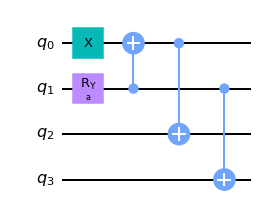

In [6]:
varform_4qubits_1param = QuantumCircuit(4)
a = Parameter('a')

varform_4qubits_1param.ry(a,1)
varform_4qubits_1param.x(0)
varform_4qubits_1param.cx(1,0)
varform_4qubits_1param.cx(0,2)
varform_4qubits_1param.cx(1,3)

varform_4qubits_1param.draw('mpl')

And the 3 parameter basis spanned by $|0101\rangle$, $|0110\rangle$, $|1001\rangle$ and $|1010\rangle$.

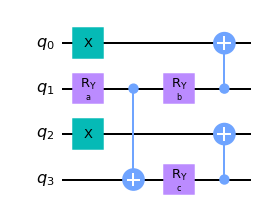

In [7]:
varform_4qubits_3params = QuantumCircuit(4)
a = Parameter('a')
b = Parameter('b')
c = Parameter('c')

varform_4qubits_3params.x(0)
varform_4qubits_3params.x(2)
varform_4qubits_3params.ry(a,1)
varform_4qubits_3params.cx(1,3)
varform_4qubits_3params.ry(b,1)
varform_4qubits_3params.ry(c,3)
varform_4qubits_3params.cx(1,0)
varform_4qubits_3params.cx(3,2)

varform_4qubits_3params.draw('mpl')

Now we need to map the Hamiltonian to a quantum circuit. We will use the Jordan-Wigner mapping and the basic evaluator. We will run it on the qasm simulator for testing. Start by initializing all the elements necessary for the computation.

In [8]:
from mapping import JordanWigner, Parity
from evaluator import BasicEvaluator, BitwiseCommutingCliqueEvaluator
from solver import VQESolver
from qiskit import Aer, execute
from scipy.optimize import minimize
import time

In [9]:
mapping = JordanWigner()
varform = varform_4qubits_1param
backend = Aer.get_backend('qasm_simulator')
execute_opts = {'shots' : 2048}
minimizer = lambda fct, start_param_values : minimize(
    fct,
    start_param_values,
    method = 'SLSQP', 
    options = {'maxiter' : 5, 'eps' : 1e-1, 'ftol' : 1e-4, 'disp' : True, 'iprint' : 0})
evaluator = BasicEvaluator(varform,backend,execute_opts = execute_opts)
solver = VQESolver(evaluator,minimizer,[0],name = 'jw_basic')
#Test for the optimal distance
t0 = time.time()
molecular_hamiltonian = MolecularFermionicHamiltonian.from_integrals(h1_no_spin[106],h2_no_spin[106]).include_spin()
lcps = mapping.fermionic_hamiltonian_to_linear_combinaison_pauli_string(molecular_hamiltonian).combine().apply_threshold().sort()
t2 = time.time()
print(t2-t0)
en, par = solver.lowest_eig_value(lcps)
print(en,par)

0.08099330501863733
[-1.86194606] [-0.17793741]


Now we run the calculation using all the machinery and looping over the distances between the atoms. We monitor time to compare to other methods

In [10]:
en_jw1_basic = np.zeros(len(dist))
par_jw1_basic = np.zeros(len(dist))
t0 = time.time()
for i,(h1,h2) in enumerate(zip(h1_no_spin,h2_no_spin)):
    molecular_hamiltonian = MolecularFermionicHamiltonian.from_integrals(h1,h2).include_spin()
    lcps = mapping.fermionic_hamiltonian_to_linear_combinaison_pauli_string(molecular_hamiltonian).combine().apply_threshold().sort()
    en_jw1_basic[i], par_jw1_basic[i] = solver.lowest_eig_value(lcps)
t_jw1_basic = time.time()-t0
print(t_jw1_basic)

2982.9476904200274


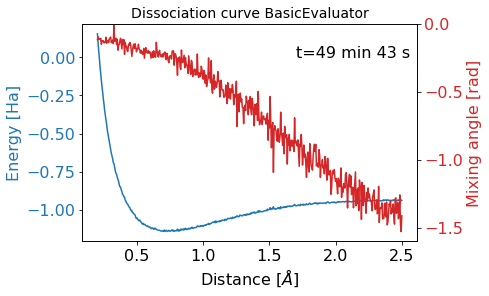

In [19]:
plt.title("Dissociation curve BasicEvaluator",fontsize=14)
plt.plot(dist,en_jw1_basic+energy_nuc)
plt.text(1.7,0,"t={m:.0f} min {s:.0f} s".format(m=t_jw1_basic//60, s=t_jw1_basic%60),fontsize=16)
plt.xlabel('Distance $[\\AA]$', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.ylabel('Energy [Ha]', color="tab:blue", fontsize=16)
plt.tick_params(axis='y', labelcolor="C0",labelsize=16)
plt.twinx()
plt.plot(dist,par_jw1_basic,color="C3")
plt.ylim(-1.6,0)
plt.ylabel('Mixing angle [rad]', color="tab:red", fontsize=16)
plt.tick_params(axis='y', labelcolor="C3",labelsize=16)
plt.show()

Now we compare the above to the BitwiseCommutingCliqueEvaluator to see if there's any performance improvement

In [12]:
evaluator = BitwiseCommutingCliqueEvaluator(varform,backend,execute_opts = execute_opts)
solver = VQESolver(evaluator,minimizer,[0],name = 'jw_bitwise')

In [13]:
en_jw1_bitwise = np.zeros(len(dist))
par_jw1_bitwise = np.zeros(len(dist))
t0 = time.time()
for i,(h1,h2) in enumerate(zip(h1_no_spin,h2_no_spin)):
    molecular_hamiltonian = MolecularFermionicHamiltonian.from_integrals(h1,h2).include_spin()
    lcps = mapping.fermionic_hamiltonian_to_linear_combinaison_pauli_string(molecular_hamiltonian).combine().apply_threshold().sort()
    en_jw1_bitwise[i], par_jw1_bitwise[i] = solver.lowest_eig_value(lcps)
t_jw1_bitwise = time.time()-t0
print(t_jw1_bitwise)

2626.712345167005


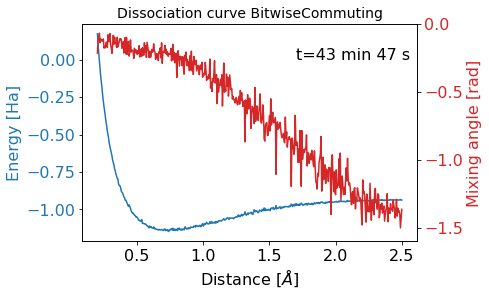

In [21]:
plt.title("Dissociation curve BitwiseCommuting",fontsize=14)
plt.plot(dist,en_jw1_bitwise+energy_nuc)
plt.text(1.7,0,"t={m:.0f} min {s:.0f} s".format(m=t_jw1_bitwise//60, s=t_jw1_bitwise%60),fontsize=16)
plt.xlabel('Distance $[\\AA]$', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.ylabel('Energy [Ha]', color="tab:blue", fontsize=16)
plt.tick_params(axis='y', labelcolor="C0",labelsize=16)
plt.twinx()
plt.plot(dist,par_jw1_bitwise,color="C3")
plt.ylim(-1.6,0)
plt.ylabel('Mixing angle [rad]', color="tab:red", fontsize=16)
plt.tick_params(axis='y', labelcolor="C3",labelsize=16)
plt.show()

Here we try to get the Parity mapping to work.

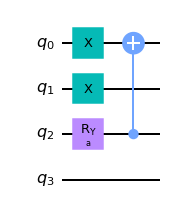

In [15]:
varform_2qubits_1param = QuantumCircuit(4)
a = Parameter('a')

varform_2qubits_1param.x(0)
varform_2qubits_1param.x(1)
varform_2qubits_1param.ry(a,2)
varform_2qubits_1param.cx(2,0)

varform_2qubits_1param.draw('mpl')

In [16]:
%autoreload
mapping = Parity()
varform = varform_2qubits_1param
evaluator = BitwiseCommutingCliqueEvaluator(varform,backend,execute_opts = execute_opts)
solver = VQESolver(evaluator,minimizer,[0],name = 'parity_basic')
#Test for the optimal distance
t0=time.time()
molecular_hamiltonian = MolecularFermionicHamiltonian.from_integrals(h1_no_spin[106],h2_no_spin[106]).include_spin()
lcps = mapping.fermionic_hamiltonian_to_linear_combinaison_pauli_string(molecular_hamiltonian).combine().apply_threshold().sort()
t2=time.time()
print(t2-t0)
en, par = solver.lowest_eig_value(lcps)
print(en,par)

0.08193976699840277
[-1.8667856] [-0.20422324]


In [17]:
en_parity_bitwise = np.zeros(len(dist))
par_parity_bitwise = np.zeros(len(dist))
t0 = time.time()
for i,(h1,h2) in enumerate(zip(h1_no_spin,h2_no_spin)):
    molecular_hamiltonian = MolecularFermionicHamiltonian.from_integrals(h1,h2).include_spin()
    lcps = mapping.fermionic_hamiltonian_to_linear_combinaison_pauli_string(molecular_hamiltonian).combine().apply_threshold().sort()
    en_parity_bitwise[i], par_parity_bitwise[i] = solver.lowest_eig_value(lcps)
t_parity_bitwise = time.time()-t0
print(t_parity_bitwise)

2635.9344858200056


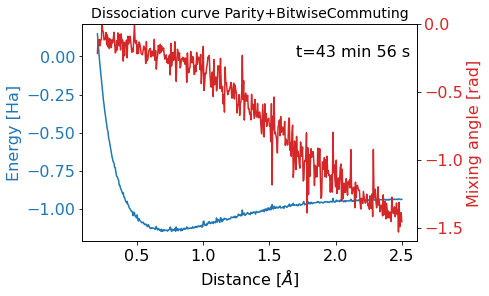

In [22]:
plt.title("Dissociation curve Parity+BitwiseCommuting",fontsize=14)
plt.plot(dist,en_parity_bitwise+energy_nuc)
plt.text(1.7,0,"t={m:.0f} min {s:.0f} s".format(m=t_parity_bitwise//60, s=t_parity_bitwise%60),fontsize=16)
plt.xlabel('Distance $[\\AA]$', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.ylabel('Energy [Ha]', color="tab:blue", fontsize=16)
plt.tick_params(axis='y', labelcolor="C0",labelsize=16)
plt.twinx()
plt.plot(dist,par_parity_bitwise,color="C3")
plt.ylim(-1.6,0)
plt.ylabel('Mixing angle [rad]', color="tab:red", fontsize=16)
plt.tick_params(axis='y', labelcolor="C3",labelsize=16)
plt.show()